In [1]:
%matplotlib inline

from scipy import signal
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import os.path as path
import cv2
outdir = '/home/eric/Phd_thesis/figures/'
# # # Using seaborn's style
# # plt.style.use('seaborn')

# # width = 345

# nice_fonts = {
#         # Use LaTeX to write all text
#         "text.usetex": True,
#         "font.family": "serif",
#         # Use 10pt font in plots, to match 10pt font in document
#         "axes.labelsize": 10,
#         "font.size": 10,
#         # Make the legend/label fonts a little smaller
#         "legend.fontsize": 8,
#         "xtick.labelsize": 8,
#         "ytick.labelsize": 8,
# }

# mpl.rcParams.update(nice_fonts)
# print("Your style sheets are located at: {}".format(path.join(mpl.__path__[0], 'mpl-data', 'stylelib')))
from my_plot import set_size
from matplotlib import cm
width_pt = 506.45#'thesis'# 
plt.style.use('tex')
output_dir = '/home/eric/Phd_thesis/figures/'

In [2]:
def calc_luminance(img):
    L = img[:, :, 0] * 0.2125  + img[:, :, 0] * 0.7154  + img[:, :, 0] * 0.0721
    return L

def normalize_img(img, rows, cols):
    img_nrmzd =  (img * (np.sqrt(rows*cols))) / np.sqrt(np.sum(np.abs(img)**2))#
    return img_nrmzd

def linear_normalization(arr, nmax, nmin):
    minarr = np.min(arr)
    maxarr = np.max(arr)
    return (arr - minarr) * ((nmax - nmin)/ (maxarr - minarr)) + nmin

def linear_normalization2(arr):
    arr //= 2.
    arr += 128. 
    
    return arr

def hexencode(rgb):
    """Transform an RGB tuple to a hex string (html color)"""
    r=int(rgb[0])
    g=int(rgb[1])
    b=int(rgb[2])
    return '#%02x%02x%02x' % (r,g,b)

def img2complex_colorspace(img, color_space):
    # see https://docs.opencv.org/trunk/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv for color space transformation info
    
#     img = img_as_float32(img.astype('uint8')) # The input image must be float32 between [0, 1]
    
    if color_space == 'HV':
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        ch1 = np.deg2rad(img_hsv[:, :, 0]) # Change the H channel from deg to rag #img_hsv[:, :, 0]#
        ch2 = img_hsv[:, :, 1] * 255. #* 100. # Change the S channel between [0, 1]
        ch3 = img_hsv[:, :, 2] * 255. #* 100. # Change the V channel between [0, 1]
        
        luminance = ch2
        chrominance = ch3 * np.exp(1j * ch1)
        chrominance_real = chrominance.real
        chrominance_imag = chrominance.imag
        cs = 'HSV'
   
    if color_space == 'HLS':
        img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype('float32')
        ch1 = np.deg2rad(img_hls[:, :, 0]) * 2# Change the H channel from deg to rag #img_hsv[:, :, 0]#
        ch2 = img_hls[:, :, 1] #* 255. #* 100. # Change the L channel between [0, 1]
        ch3 = img_hls[:, :, 2] #* 255. #* 100. # Change the S channel between [0, 1]
        
        luminance = ch2
        chrominance = ch3 * np.exp(1j * ch1)
        chrominance_real = chrominance.real
        chrominance_imag = chrominance.imag
        cs = 'HLS'
            
    if color_space == 'HS':
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype('float32')
        ch1 = np.deg2rad(img_hsv[:, :, 0])*2 # Change the H channel from deg to rag img_hsv[:, :, 0]#
        ch2 = img_hsv[:, :, 1] #* 255. #* 100. # Change the S channel between [0, 1]
        ch3 = img_hsv[:, :, 2] #* 255. #* 100. # Change the V channel between [0, 1]
        
        luminance = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float32')#calc_luminance(img) #ch3#ch3 #
        chrominance = ch2 * np.exp(1j * ch1)
        chrominance_real = chrominance.real
        chrominance_imag = chrominance.imag
        cs = 'HSV'
   
    if color_space == 'LAB':
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        ch1 = img_lab[:, :, 0]  # L channel between [0, 100]
        ch2 = img_lab[:, :, 1]  # a channel between [-127, 127]
        ch3 = img_lab[:, :, 2]  # b channel between [-127, 127]
        
        luminance = ch1
        chrominance = ch2 + (1j * ch3)
        chrominance_real = chrominance.real
        chrominance_imag = chrominance.imag
        cs = 'LAB'
        
#     fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
#     axs[0].imshow(ch1, cmap='gray')
#     axs[1].imshow(ch2, cmap='gray')
#     axs[2].imshow(ch3, cmap='gray')
#     fig.suptitle('Image channels in '+ cs +' color space')
    
    return luminance, chrominance_real, chrominance_imag

def tonemap(img, lum, f, m, a, c):
    lum = lum[..., np.newaxis]
    Cva = np.mean(img, axis=-1)
    Lav = np.mean(lum)
    Llav = np.log(Lav)
    Lmin = np.min(lum)
    Lmax = np.max(lum)
    
    f = np.exp(-f)
    if m == 0:
        k = (np.log(Lmax)-Llav) / (np.log(Lmax)-np.log(Lmin))
        m = 0.3 +0.7* (k **1.4)
    pdb.set_trace()
    I_l = np.sum(c * img , (1-c) * lum)
    I_g = c * Cav + (1-c) * Lav
    I_a = a + I_l + (1-a) * I_g
    return I_a

def calc_semisat(lum, m=0, f=0):
    lum = lum
#     Cva = np.mean(img, axis=-1)
    Lav = np.mean(lum)
    Llav = np.log(Lav)
    Lmin = np.min(lum)
    Lmax = np.max(lum)
    
    f = np.exp(-f)
    pdb.set_trace()
    if m == 0:
        k = (np.log(Lmax)-Llav) / (np.log(Lmax)-np.log(Lmin))
        print k
        m = 0.3 + 0.7 * (k ** 1.4)
    
    return f * (Lav ** m)

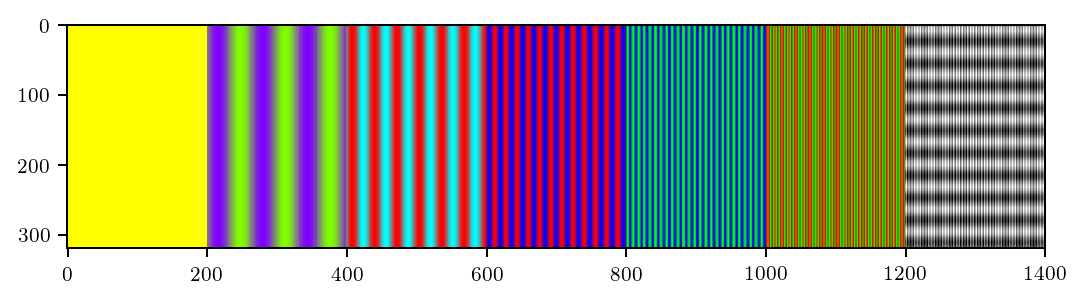

In [3]:
rows, cols, channels = 320, 1400, 3
s_interval = np.int(200)  # Spacial interval to change the frequency of the texture
f_1 = 1/16.

# f1, f2, f3, f4, f5 = [1/2., 1/4., 1/8., 1/16., 1/32.]#1/2., 
f1, f2, f3, f4, f5 = [1/64., 1/32., 1/16., 1/8., 1/4.]#1/2., 
# f1, f2, f3, f4, f5 = [1/70., 1/64., 1/70., 1/70.,1/70., ]#1/2., 

[X, Y] = np.meshgrid(np.arange(cols), np.arange(rows))
x = np.arange(cols)
ang = 0.
x1 = (X * np.cos(np.deg2rad(ang))) + (Y * np.sin(np.deg2rad(ang)))
x2 = (X * np.cos(np.deg2rad(ang+90.))) + (Y * np.sin(np.deg2rad(ang+90.)))

#########
rg_ch1 = np.sin(2 * np.pi * f5 * x1) 
rg_ch1 = (rg_ch1 - np.min(rg_ch1)) / (np.max(rg_ch1) - np.min(rg_ch1)) * 255.

gb_ch1 = np.sin(2 * np.pi * f4 * x1 ) * 0.

br_ch1 = np.sin(2 * np.pi * f3 * x1 + np.pi) 
br_ch1 = (br_ch1 - np.min(br_ch1)) / (np.max(br_ch1) - np.min(br_ch1)) * 255.

re_ch1 = np.sin(2 * np.pi * f2 * x1 ) 
re_ch1 = (re_ch1 - np.min(re_ch1)) / (np.max(re_ch1) - np.min(re_ch1)) * 255.

im_ch1 = 0.5*(np.sin(2 * np.pi * f1 * x1)) + 0.5*(np.sin((2 * np.pi * f1 * x1 )+ np.pi)) 
im_ch1 = (im_ch1 - np.min(im_ch1)) / (np.max(im_ch1) - np.min(im_ch1)) * 255.

nb_ch1 = np.sin(2 * np.pi * f5 * x1) + np.sin(2 * np.pi * f2 * x2) 
nb_ch1 = (nb_ch1 - np.min(nb_ch1)) / (np.max(nb_ch1) - np.min(nb_ch1)) * 255.

gray_ch1 = np.ones((rows, cols)) * 255. 
                    
# img_r = np.column_stack((rg_ch1[:, 0:s_interval], gb_ch1[:, 0:s_interval], br_ch1[:, 0:s_interval], re_ch1[:, 0:s_interval], im_ch1[:, 0:s_interval], nb_ch1[:, 0:s_interval], gray_ch1[:, 0:s_interval]))
img_r = np.column_stack((gray_ch1[:, 0:s_interval], im_ch1[:, 0:s_interval], re_ch1[:, 0:s_interval], br_ch1[:, 0:s_interval], gb_ch1[:, 0:s_interval], rg_ch1[:, 0:s_interval], nb_ch1[:, 0:s_interval]))

#########
rg_ch2 = np.sin(2 * np.pi * f5 * x1 + np.pi)
rg_ch2 = (rg_ch2 - np.min(rg_ch2)) / (np.max(rg_ch2) - np.min(rg_ch2)) * 255.

gb_ch2 = np.sin(2 * np.pi * f4 * x1) 
gb_ch2 = (gb_ch2 - np.min(gb_ch2)) / (np.max(gb_ch2) - np.min(gb_ch2)) * 255.

br_ch2 = np.sin(2 * np.pi * f3 * x1 + np.pi) * 0.

re_ch2 = np.sin(2 * np.pi * f2 * x1 + np.pi)
re_ch2 = (re_ch2 - np.min(re_ch2)) / (np.max(re_ch2) - np.min(re_ch2)) * 255.

im_ch2 = np.sin(2 * np.pi * f1 * x1 + np.pi) 
im_ch2 = (im_ch2 - np.min(im_ch2)) / (np.max(im_ch2) - np.min(im_ch2)) * 255.

nb_ch2 = np.sin(2 * np.pi * f5 * x1) + np.sin(2 * np.pi * f2 * x2) 
nb_ch2 = (nb_ch2 - np.min(nb_ch2)) / (np.max(nb_ch2) - np.min(nb_ch2)) * 255.

gray_ch2 = np.ones((rows, cols)) * 255.

# img_g = np.column_stack((rg_ch2[:, 0:s_interval], gb_ch2[:, 0:s_interval], br_ch2[:, 0:s_interval], re_ch2[:, 0:s_interval], im_ch2[:, 0:s_interval], nb_ch2[:, 0:s_interval], gray_ch2[:, 0:s_interval]))
img_g = np.column_stack((gray_ch2[:, 0:s_interval], im_ch2[:, 0:s_interval], re_ch2[:, 0:s_interval], br_ch2[:, 0:s_interval], gb_ch2[:, 0:s_interval], rg_ch2[:, 0:s_interval], nb_ch2[:, 0:s_interval]))

#########

rg_ch3 = np.sin(2 * np.pi * f5 * x1) * 0. 

gb_ch3 = np.sin(2 * np.pi * f4 * x1 + np.pi) 
gb_ch3 = (gb_ch3 - np.min(gb_ch3)) / (np.max(gb_ch3) - np.min(gb_ch3)) * 255.

br_ch3 = np.sin(2 * np.pi * f3 * x1) 
br_ch3 = (br_ch3 - np.min(br_ch3)) / (np.max(br_ch3) - np.min(br_ch3)) * 255.

re_ch3 = np.sin(2 * np.pi * f2 * x1 + np.pi)
re_ch3 = (re_ch3 - np.min(re_ch3)) / (np.max(re_ch3) - np.min(re_ch3)) * 255.

im_ch3 = np.sin(2 * np.pi * f1 * x1) 
im_ch3 = (im_ch3 - np.min(im_ch3)) / (np.max(im_ch3) - np.min(im_ch3)) * 255.

nb_ch3 = np.sin(2 * np.pi * f5 * x1) + np.sin(2 * np.pi * f2 * x2) 
nb_ch3 = (nb_ch3 - np.min(nb_ch3)) / (np.max(nb_ch3) - np.min(nb_ch3)) * 255.

gray_ch3 = np.ones((rows, cols)) * 0.

# img_b = np.hstack((rg_ch3[:, 0:s_interval], gb_ch3[:, 0:s_interval], br_ch3[:, 0:s_interval], re_ch3[:, 0:s_interval], im_ch3[:, 0:s_interval], nb_ch3[:, 0:s_interval], gray_ch3[:, 0:s_interval]))
img_b = np.column_stack((gray_ch3[:, 0:s_interval], im_ch3[:, 0:s_interval], re_ch3[:, 0:s_interval], br_ch3[:, 0:s_interval], gb_ch3[:, 0:s_interval], rg_ch3[:, 0:s_interval], nb_ch3[:, 0:s_interval]))

img_orig = np.zeros((rows, cols, channels), dtype=np.uint8)
img_orig[:, :, 0] = img_r
img_orig[:, :, 1] = img_g
img_orig[:, :, 2] = img_b

# img_orig = np.int(img_orig - img_orig.mean())

plt.figure(figsize=set_size(width=width_pt, fraction=1), dpi=180)
plt.imshow(img_orig)
# plt.savefig(output_dir + 'synthetic_image_color_texture.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('synthetic_image_color_texture.pdf', format='pdf', bbox_inches='tight')

# plt.title('Input image (RGB)', fontsize=10)   


255.0


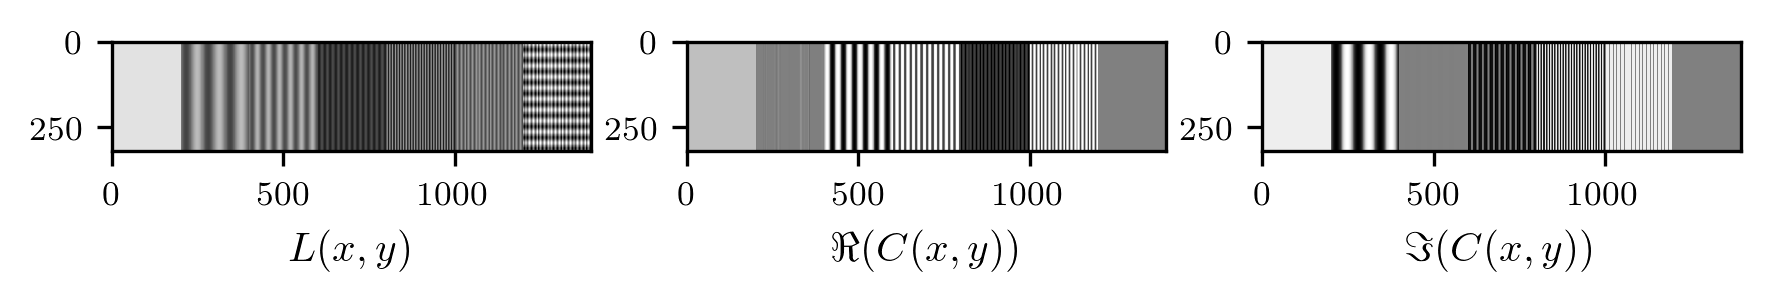

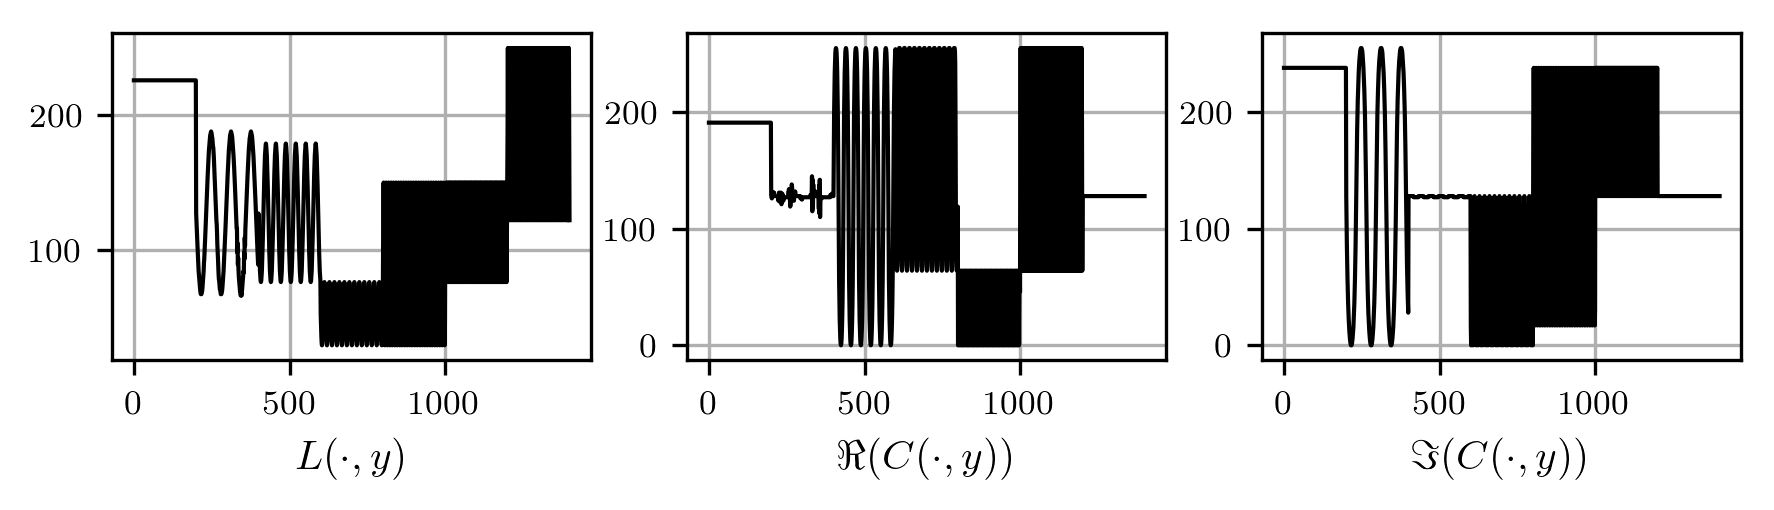

In [26]:
color_space = 'HS'
lum, chrom_r, chrom_i = img2complex_colorspace(img_orig, color_space)

lum = linear_normalization(lum, 255., 0.)
chrom_r = linear_normalization2(chrom_r)
chrom_i = linear_normalization2(chrom_i)
print np.max(chrom_r)

fig, axs = plt.subplots(1, 3, figsize=set_size(width_pt, subplots=(1., 3.)), dpi=300)
axs[0].imshow(lum, cmap='gray')
axs[0].set_xlabel(r'$L(x,y)$')
axs[1].imshow(chrom_r, cmap='gray')
axs[1].set_xlabel(r'$\Re(C(x,y))$')
axs[2].imshow(chrom_i, cmap='gray')
axs[2].set_xlabel(r'$\Im(C(x,y))$')

# plt.savefig(output_dir + 'synthetic_image_three_channel_decomposition.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('synthetic_image_three_channel_decomposition.pdf', format='pdf', bbox_inches='tight')

fig, axs = plt.subplots(1, 3, figsize=set_size(width_pt, subplots=(1., 3.)), dpi=300)
axs[0].plot(x, lum[170, :], 'k', lw=1)
axs[0].grid(True)
axs[0].set_xlabel(r'$L(\cdot, y)$')
axs[1].plot(x, chrom_r[170, :], 'k', lw=1)
axs[1].grid(True)
axs[1].set_xlabel(r'$\Re(C(\cdot, y))$')
axs[2].plot(x, chrom_i[170, :], 'k', lw=1)
axs[2].grid(True)
axs[2].set_xlabel(r'$\Im(C(\cdot, y))$')

# plt.savefig(output_dir + 'horizontal_line_three_channel_decomposition.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('horizontal_line_three_channel_decomposition.pdf', format='pdf', bbox_inches='tight')

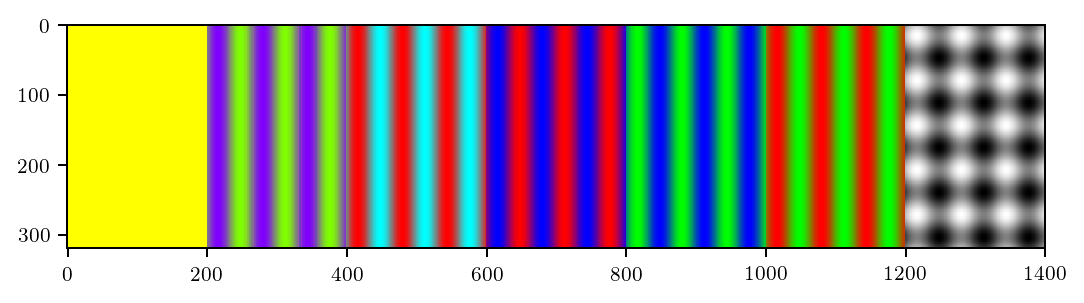

In [8]:
rows, cols, channels = 320, 1400, 3
s_interval = np.int(200)  # Spacial interval to change the frequency of the texture
f_1 = 1/16.

# f1, f2, f3, f4, f5 = [1/2., 1/4., 1/8., 1/16., 1/32.]#1/2., 
# f1, f2, f3, f4, f5 = [1/64., 1/32., 1/16., 1/8., 1/4.]#1/2., 
f1, f2, f3, f4, f5 = [1/64., 1/64., 1/64., 1/64.,1/64.]#1/2., 

[X, Y] = np.meshgrid(np.arange(cols), np.arange(rows))
x = np.arange(cols)
ang = 0.
x1 = (X * np.cos(np.deg2rad(ang))) + (Y * np.sin(np.deg2rad(ang)))
x2 = (X * np.cos(np.deg2rad(ang+90.))) + (Y * np.sin(np.deg2rad(ang+90.)))

#########
rg_ch1 = np.sin(2 * np.pi * f5 * x1) 
rg_ch1 = (rg_ch1 - np.min(rg_ch1)) / (np.max(rg_ch1) - np.min(rg_ch1)) * 255.

gb_ch1 = np.sin(2 * np.pi * f4 * x1 ) * 0.

br_ch1 = np.sin(2 * np.pi * f3 * x1 + np.pi) 
br_ch1 = (br_ch1 - np.min(br_ch1)) / (np.max(br_ch1) - np.min(br_ch1)) * 255.

re_ch1 = np.sin(2 * np.pi * f2 * x1 ) 
re_ch1 = (re_ch1 - np.min(re_ch1)) / (np.max(re_ch1) - np.min(re_ch1)) * 255.

im_ch1 = 0.5*(np.sin(2 * np.pi * f1 * x1)) + 0.5*(np.sin((2 * np.pi * f1 * x1 )+ np.pi)) 
im_ch1 = (im_ch1 - np.min(im_ch1)) / (np.max(im_ch1) - np.min(im_ch1)) * 255.

nb_ch1 = np.sin(2 * np.pi * f5 * x1) + np.sin(2 * np.pi * f2 * x2) 
nb_ch1 = (nb_ch1 - np.min(nb_ch1)) / (np.max(nb_ch1) - np.min(nb_ch1)) * 255.

gray_ch1 = np.ones((rows, cols)) * 255. 
                    
# img_r = np.column_stack((rg_ch1[:, 0:s_interval], gb_ch1[:, 0:s_interval], br_ch1[:, 0:s_interval], re_ch1[:, 0:s_interval], im_ch1[:, 0:s_interval], nb_ch1[:, 0:s_interval], gray_ch1[:, 0:s_interval]))
img_r = np.column_stack((gray_ch1[:, 0:s_interval], im_ch1[:, 0:s_interval], re_ch1[:, 0:s_interval], br_ch1[:, 0:s_interval], gb_ch1[:, 0:s_interval], rg_ch1[:, 0:s_interval], nb_ch1[:, 0:s_interval]))

#########
rg_ch2 = np.sin(2 * np.pi * f5 * x1 + np.pi)
rg_ch2 = (rg_ch2 - np.min(rg_ch2)) / (np.max(rg_ch2) - np.min(rg_ch2)) * 255.

gb_ch2 = np.sin(2 * np.pi * f4 * x1) 
gb_ch2 = (gb_ch2 - np.min(gb_ch2)) / (np.max(gb_ch2) - np.min(gb_ch2)) * 255.

br_ch2 = np.sin(2 * np.pi * f3 * x1 + np.pi) * 0.

re_ch2 = np.sin(2 * np.pi * f2 * x1 + np.pi)
re_ch2 = (re_ch2 - np.min(re_ch2)) / (np.max(re_ch2) - np.min(re_ch2)) * 255.

im_ch2 = np.sin(2 * np.pi * f1 * x1 + np.pi) 
im_ch2 = (im_ch2 - np.min(im_ch2)) / (np.max(im_ch2) - np.min(im_ch2)) * 255.

nb_ch2 = np.sin(2 * np.pi * f5 * x1) + np.sin(2 * np.pi * f2 * x2) 
nb_ch2 = (nb_ch2 - np.min(nb_ch2)) / (np.max(nb_ch2) - np.min(nb_ch2)) * 255.

gray_ch2 = np.ones((rows, cols)) * 255.

# img_g = np.column_stack((rg_ch2[:, 0:s_interval], gb_ch2[:, 0:s_interval], br_ch2[:, 0:s_interval], re_ch2[:, 0:s_interval], im_ch2[:, 0:s_interval], nb_ch2[:, 0:s_interval], gray_ch2[:, 0:s_interval]))
img_g = np.column_stack((gray_ch2[:, 0:s_interval], im_ch2[:, 0:s_interval], re_ch2[:, 0:s_interval], br_ch2[:, 0:s_interval], gb_ch2[:, 0:s_interval], rg_ch2[:, 0:s_interval], nb_ch2[:, 0:s_interval]))

#########

rg_ch3 = np.sin(2 * np.pi * f5 * x1) * 0. 

gb_ch3 = np.sin(2 * np.pi * f4 * x1 + np.pi) 
gb_ch3 = (gb_ch3 - np.min(gb_ch3)) / (np.max(gb_ch3) - np.min(gb_ch3)) * 255.

br_ch3 = np.sin(2 * np.pi * f3 * x1) 
br_ch3 = (br_ch3 - np.min(br_ch3)) / (np.max(br_ch3) - np.min(br_ch3)) * 255.

re_ch3 = np.sin(2 * np.pi * f2 * x1 + np.pi)
re_ch3 = (re_ch3 - np.min(re_ch3)) / (np.max(re_ch3) - np.min(re_ch3)) * 255.

im_ch3 = np.sin(2 * np.pi * f1 * x1) 
im_ch3 = (im_ch3 - np.min(im_ch3)) / (np.max(im_ch3) - np.min(im_ch3)) * 255.

nb_ch3 = np.sin(2 * np.pi * f5 * x1) + np.sin(2 * np.pi * f2 * x2) 
nb_ch3 = (nb_ch3 - np.min(nb_ch3)) / (np.max(nb_ch3) - np.min(nb_ch3)) * 255.

gray_ch3 = np.ones((rows, cols)) * 0.

# img_b = np.hstack((rg_ch3[:, 0:s_interval], gb_ch3[:, 0:s_interval], br_ch3[:, 0:s_interval], re_ch3[:, 0:s_interval], im_ch3[:, 0:s_interval], nb_ch3[:, 0:s_interval], gray_ch3[:, 0:s_interval]))
img_b = np.column_stack((gray_ch3[:, 0:s_interval], im_ch3[:, 0:s_interval], re_ch3[:, 0:s_interval], br_ch3[:, 0:s_interval], gb_ch3[:, 0:s_interval], rg_ch3[:, 0:s_interval], nb_ch3[:, 0:s_interval]))

img_orig_same_freq = np.zeros((rows, cols, channels), dtype=np.uint8)
img_orig_same_freq[:, :, 0] = img_r
img_orig_same_freq[:, :, 1] = img_g
img_orig_same_freq[:, :, 2] = img_b

# img_orig = np.int(img_orig - img_orig.mean())

plt.figure(figsize=set_size(width=width_pt, fraction=1), dpi=180)
plt.imshow(img_orig_same_freq)
# plt.savefig(output_dir + 'synthetic_image_color_texture.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('synthetic_image_color_texture.pdf', format='pdf', bbox_inches='tight')

# plt.title('Input image (RGB)', fontsize=10)   

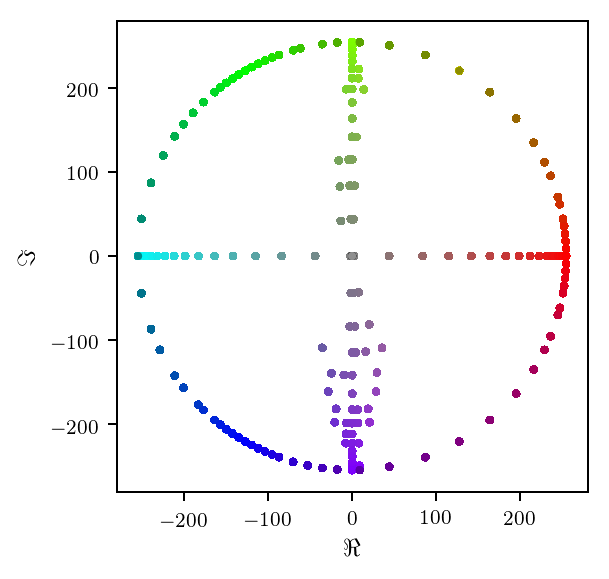

In [25]:
color_space = 'HS'
lum, chrom_r, chrom_i = img2complex_colorspace(img_orig_same_freq, color_space)


rgb_color_pixels = img_orig_same_freq.reshape((rows* cols, channels))
R = rgb_color_pixels[:, 0]
G = rgb_color_pixels[:, 1]
B = rgb_color_pixels[:, 2]

hexcode = [hexencode(rgb_color_pixels[i]) for i in range(rows*cols)]
circ_x = chrom_r
circ_y = chrom_i

plt.figure(figsize=set_size(width=width_pt, fraction=0.8), dpi=180)
ax = plt.subplot(111)
plt.scatter(circ_x, circ_y, s=10, alpha = .25, c=hexcode, lw=0)
plt.gca().set_aspect('equal', 'box')
plt.xlabel(r'$\Re$')
plt.ylabel(r'$\Im$')
# plt.savefig(output_dir + 'color_complex_plane.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('color_complex_plane.pdf', format='pdf', bbox_inches='tight')

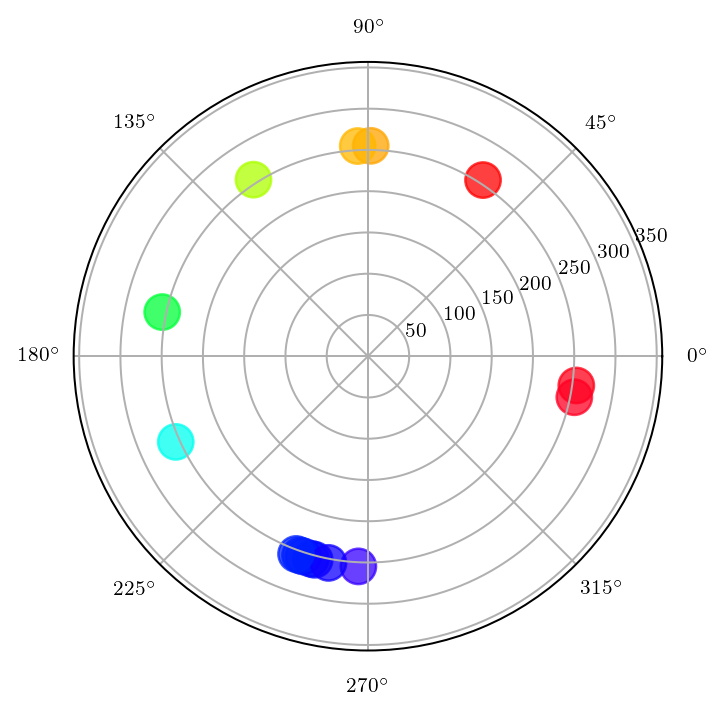

In [6]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute areas and colors
N = 15
r = 255 * np.ones(N)
theta = 2 * np.pi * np.random.rand(N)
area = 200 
colors = theta

fig = plt.figure(figsize=set_size(width=width_pt, fraction=1), dpi=180)
ax = fig.add_subplot(111, projection='polar')
ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)

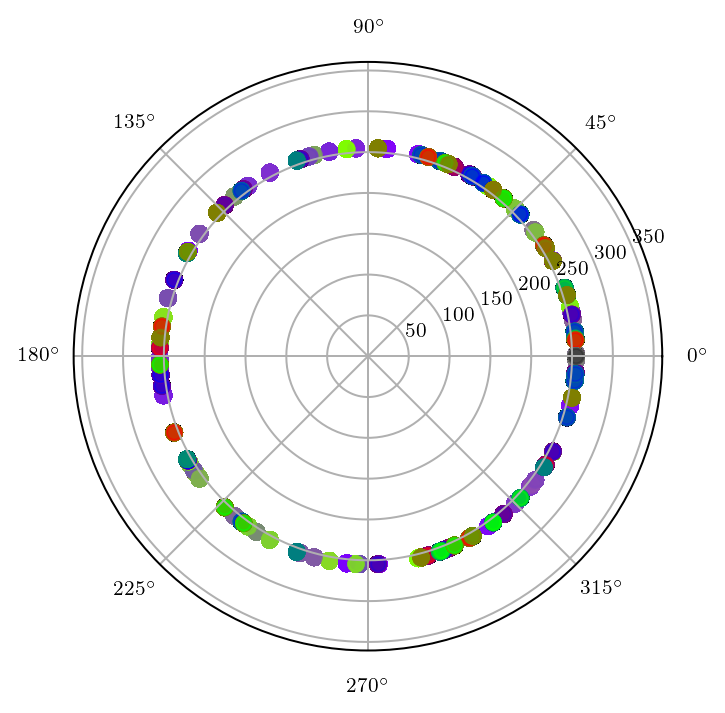

In [7]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute areas and colors
N = 15
r = 255 * np.ones(cols*rows)
theta = 2 * np.pi * np.random.rand(N)
area = 100
colors = theta

fig = plt.figure(figsize=set_size(width=width_pt, fraction=1), dpi=180)
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(chrom_i.ravel(), r, color=hexcode, alpha=0.75)